```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2022, 2023 SINTEF Digital

Investigating the effect of different flux formulations and slope
limiters for real-world oceanographic simulations

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Example of Double Jet Case

This notebook is used to make figures that illustrates the double jet case used in the results section of the IEWPF paper.

## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import pycuda.driver as cuda
import os
import sys
import datetime

from importlib import reload

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import IPythonMagic, DoubleJetCase

In [2]:
%cuda_context_handler gpu_ctx

In [3]:
#Create output directory for images
imgdir = 'double_jet'
filename_prefix = imgdir + "/" + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S") + "_"
os.makedirs(imgdir, exist_ok=True)
print("Saving images to " + imgdir)

Saving images to double_jet


In [4]:
def imshow(im, interpolation="None", title=None, figsize=(4,4), interior=False):
    fig = plt.figure(figsize=figsize)
    
    if interior:
        im = plt.imshow(im[2:-2,2:-2], interpolation=interpolation, origin='lower')
    else:
        im = plt.imshow(im, interpolation=interpolation, origin='lower')
    
    plt.colorbar()
    if title is not None:
        plt.title(title)
        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12,3), interior=False):
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    range_eta = np.max(np.abs(eta))
    range_huv = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    if interior:
        eta_im = axs[0].imshow(eta[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta)
    else:
        eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta)
    axs[0].set_title("$\eta$")
    plt.colorbar(eta_im, ax=axs[0])
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[1].set_title("$hu$")
    plt.colorbar(hu_im, ax=axs[1])

    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[2].set_title("$hv$")
    plt.colorbar(hv_im, ax=axs[2])

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()

def imshow6(eta1, hu1, hv1, eta2, hu2, hv2, interpolation="None", title=None):
    fig, axs = plt.subplots(3,3, figsize=(12,13))
    
    range_eta = max(np.max(np.abs(eta1)), np.max(np.abs(eta2)))
    range_huv = max(np.max(np.abs(hu1)), np.max(np.abs(hu2)), np.max(np.abs(hv1)), np.max(np.abs(hv2)))
    
    eta_im = axs[0,0].imshow(eta1, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta)
    axs[0,0].set_title("eta 1")
    plt.colorbar(eta_im, ax=axs[0,0])
    
    hu_im = axs[0,1].imshow(hu1, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[0,1].set_title("hu 1")
    plt.colorbar(hu_im, ax=axs[0,1])

    hv_im = axs[0,2].imshow(hv1, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[0,2].set_title("hv 1")
    plt.colorbar(hv_im, ax=axs[0,2])

    
    eta_im2 = axs[1,0].imshow(eta2, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta)
    axs[1,0].set_title("eta 2")
    plt.colorbar(eta_im, ax=axs[1,0])
    
    hu_im2 = axs[1,1].imshow(hu2, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[1,1].set_title("hu 2")
    plt.colorbar(hu_im, ax=axs[1,1])

    hv_im2 = axs[1,2].imshow(hv2, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[1,2].set_title("hv 2")
    plt.colorbar(hv_im, ax=axs[1,2])
    
    
    eta_im3 = axs[2,0].imshow(eta1 - eta2, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta)
    axs[2,0].set_title("diff eta")
    plt.colorbar(eta_im, ax=axs[2,0])
    
    hu_im3 = axs[2,1].imshow(hu1 - hu2, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[2,1].set_title("diff hu")
    plt.colorbar(hu_im, ax=axs[2,1])

    hv_im3 = axs[2,2].imshow(hv1 - hv2, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[2,2].set_title("diff hv")
    plt.colorbar(hv_im, ax=axs[2,2])

    if title is not None:
        plt.suptitle(title, fontsize=18)
    plt.tight_layout()   

# Creating a CDKLM simulator with the steady-state initial condition


In [5]:
save = False

In [6]:
def daysToSec(days):
    return days*24*60*60
def secToDays(sec):
    return round(sec/(24*60*60), 1)

In [7]:
def run_doublejet(sim):
    assert sim.t == 0.0, "Sim is already run"

    dy = sim.dy
    ny = sim.ny
    y = np.linspace(dy/2, dy*(ny-0.5), num=ny)
    y = y/1000

    eta, hu, hv = sim.download(interior_domain_only=True)

    sim.step(3*24*60*60)
    eta1, hu1, hv1 = sim.download(interior_domain_only=True)

    sim.step(3*24*60*60)
    eta2, hu2, hv2 = sim.download(interior_domain_only=True)

    sim.step(3*24*60*60)
    eta3, hu3, hv3 = sim.download(interior_domain_only=True)

    crossec_eta = eta[:, 20]
    crossec_hu = hu[:, 20]
    crossec_eta1 = eta1[:, 20]
    crossec_hu1 = hu1[:, 20]
    crossec_eta2 = eta2[:, 20]
    crossec_hu2 = hu2[:, 20]
    crossec_eta3 = eta3[:, 20]
    crossec_hu3 = hu3[:, 20]
    fig, axs = plt.subplots(1,2, figsize=(12,3))

    axs[0].plot(y, crossec_eta,  label="init")
    axs[0].plot(y, crossec_eta1, label="3 days")
    axs[0].plot(y, crossec_eta2, label="6 days")
    axs[0].plot(y, crossec_eta3, label="9 days")
    axs[0].grid()
    axs[0].set_title('$\eta$')
    axs[0].set_xlabel('$y$ (km)')
    axs[0].set_ylabel('$\eta$ (m)')
    axs[0].legend()

    axs[1].plot(y, crossec_hu,  label="init")
    axs[1].plot(y, crossec_hu1, label="3 days")
    axs[1].plot(y, crossec_hu2, label="6 days")
    axs[1].plot(y, crossec_hu3, label="9 days")
    axs[1].grid()
    axs[1].set_title('$hu$')
    axs[1].set_xlabel('$y$ (km)')
    axs[1].set_ylabel('$hu$ (m$^2$/s)')
    axs[1].legend()


    for i in range(2):
        axs[i].set_xlim([0,ny*dy/1000])

300 300
(2220.0, 666000.0) (1110.0, 1110.0)


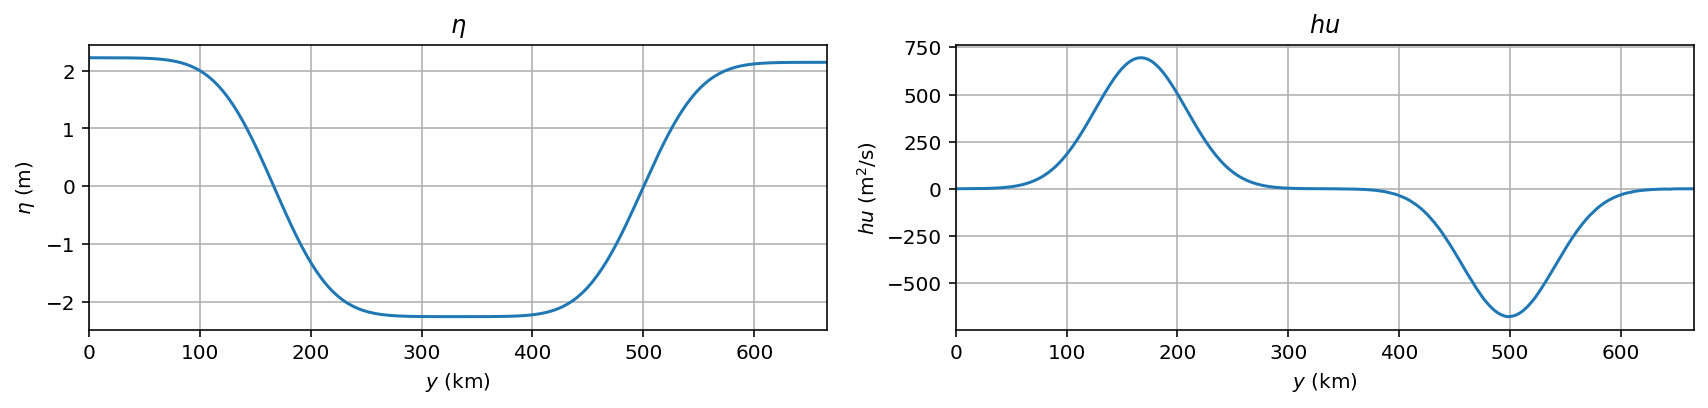

In [8]:
from importlib import reload

reload(CDKLM16)

steadyStateCase = DoubleJetCase.DoubleJetCase(gpu_ctx, model_error=False)
steadyStateCase_args, steadyStateCase_init = steadyStateCase.getInitConditions()
steadyStateCase_sim = CDKLM16.CDKLM16(**steadyStateCase_args, **steadyStateCase_init, flux_balancer=1.0)

steadyStateCase_args["dt"] = 0.0

eta, hu, hv = steadyStateCase_sim.download(interior_domain_only=True)

dy = steadyStateCase_sim.dy
ny = steadyStateCase_sim.ny
y = np.linspace(dy/2, dy*(ny-0.5), num=ny)
print(len(y), ny)
print((dy, ny*dy), (y[0], ny*dy - y[-1]))
y = y/1000

crossec_eta = eta[:, 20]
crossec_hu = hu[:, 20]

fig, axs = plt.subplots(1,2, figsize=(12,3))

eta_im = axs[0].plot(y, crossec_eta)
axs[0].grid()
axs[0].set_title('$\eta$')
axs[0].set_xlabel('$y$ (km)')
axs[0].set_ylabel('$\eta$ (m)')


hu_im = axs[1].plot(y, crossec_hu)
axs[1].grid()
axs[1].set_title('$hu$')
axs[1].set_xlabel('$y$ (km)')
axs[1].set_ylabel('$hu$ (m$^2$/s)')

for i in range(2):
    axs[i].set_xlim([0,ny*dy/1000])

plt.tight_layout()
if save: plt.savefig(filename_prefix + "initial_state.pdf", format='pdf')



In [9]:
steadyStateCase_args["f"]

0.00014048811587878725

CDKLM

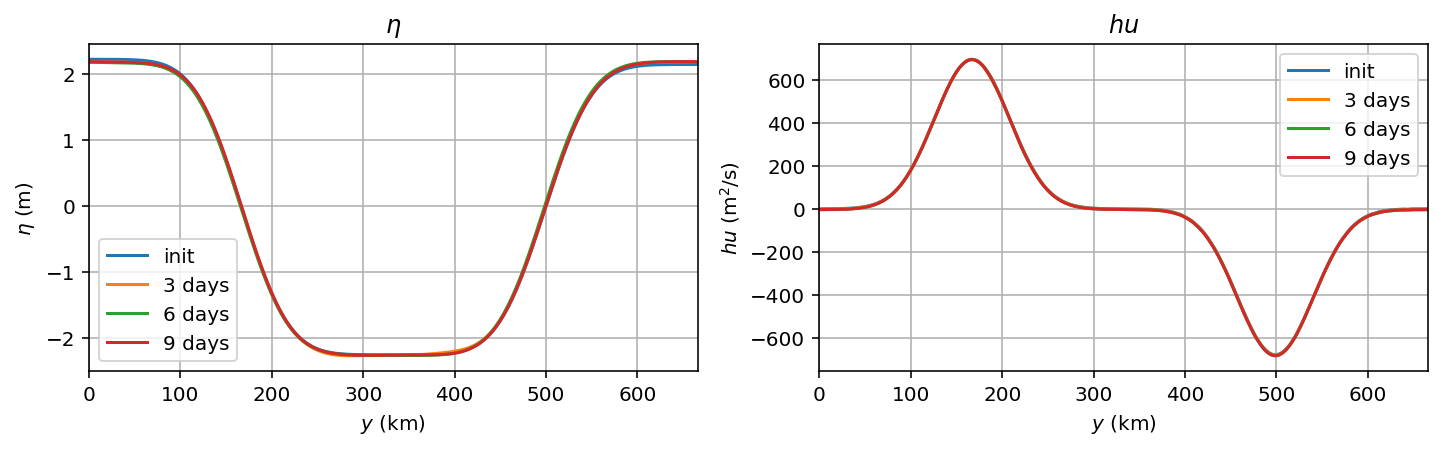

In [10]:
run_doublejet(steadyStateCase_sim)

CU with $\theta=1.0$

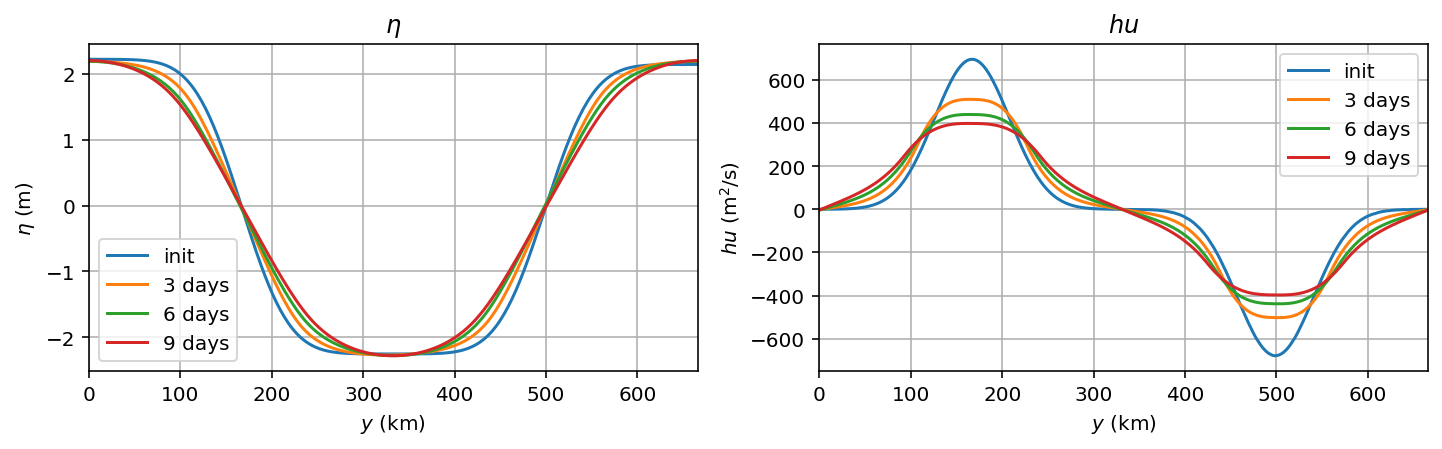

In [11]:
cu_sim1 = CDKLM16.CDKLM16(**steadyStateCase_args, **steadyStateCase_init, flux_balancer=0.0, theta=1.0)
run_doublejet(cu_sim1)

CU with $\theta=1.3$

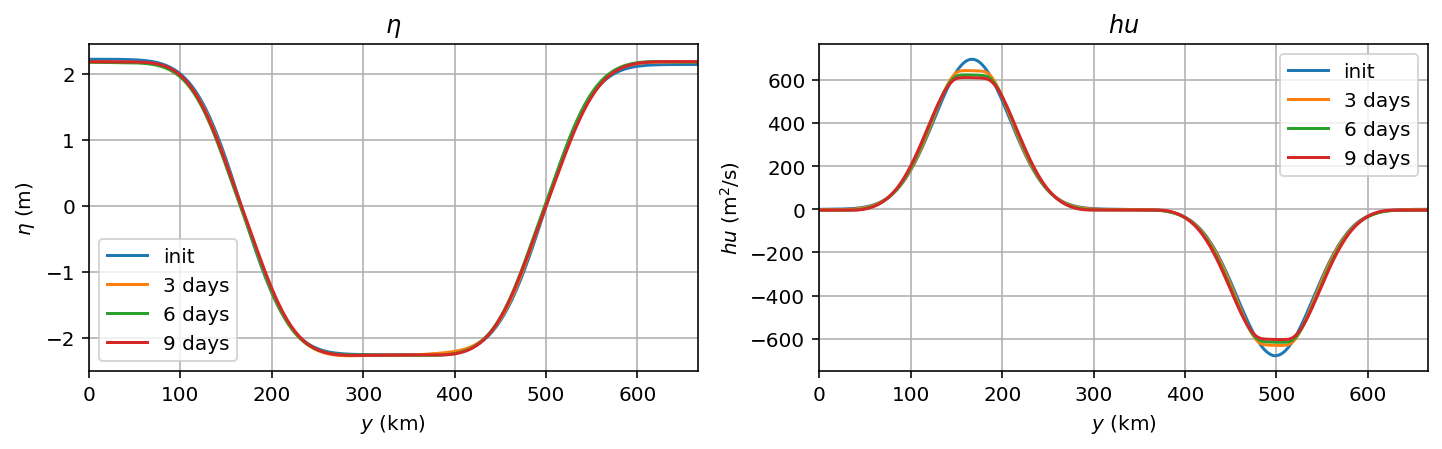

In [12]:
cu_sim2 = CDKLM16.CDKLM16(**steadyStateCase_args, **steadyStateCase_init, flux_balancer=0.0, theta=1.3)
run_doublejet(cu_sim2)

CU with $\theta=2.0$

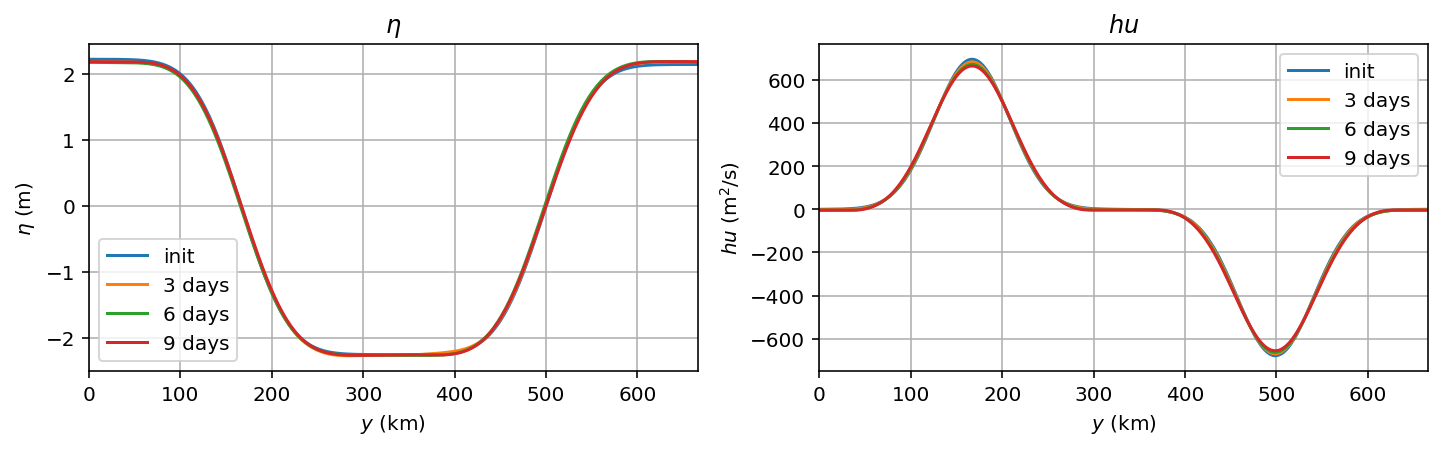

In [13]:
cu_sim3 = CDKLM16.CDKLM16(**steadyStateCase_args, **steadyStateCase_init, flux_balancer=0.0, theta=2.0)
run_doublejet(cu_sim3)

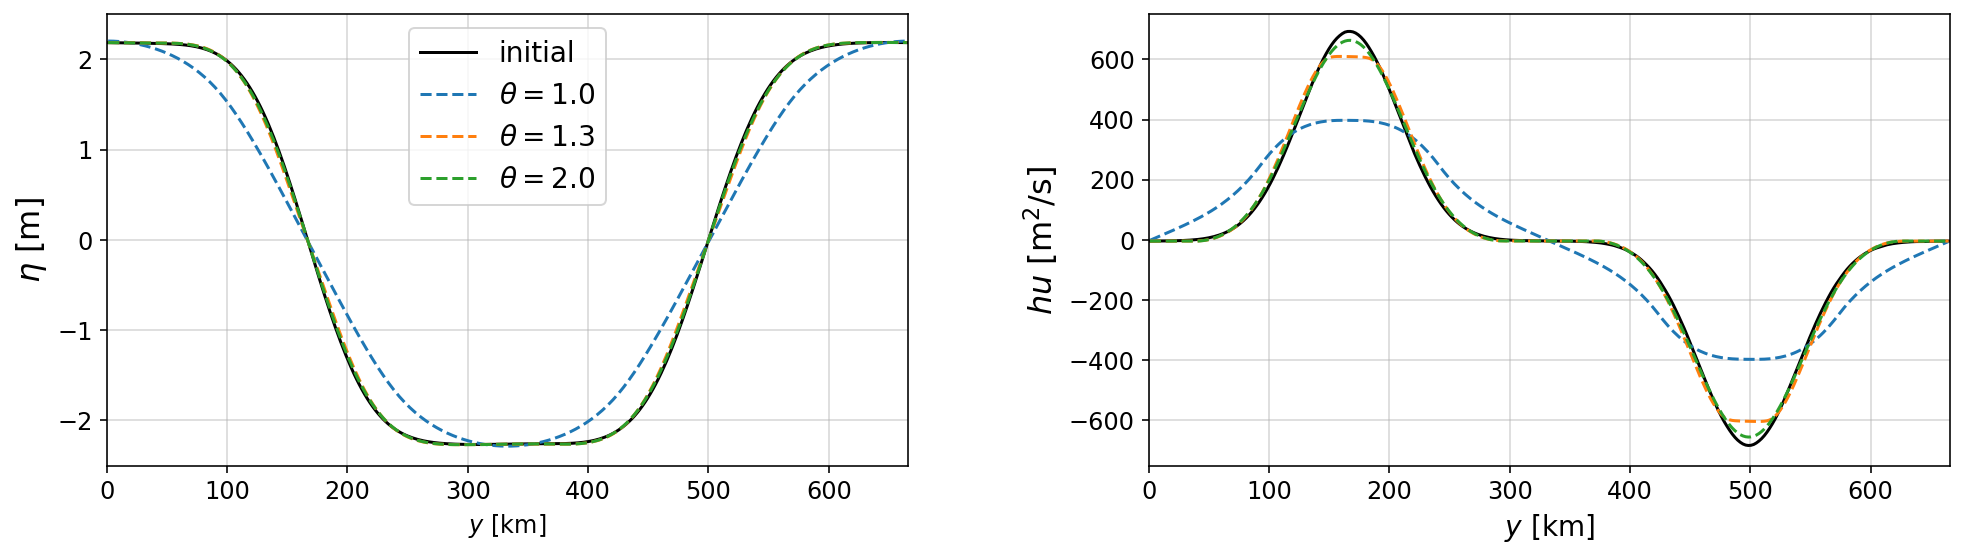

In [14]:
eta, hu, hv = steadyStateCase_sim.download(interior_domain_only=True)

eta1, hu1, hv1 = cu_sim1.download(interior_domain_only=True)

eta2, hu2, hv2 = cu_sim2.download(interior_domain_only=True)

eta3, hu3, hv3 = cu_sim3.download(interior_domain_only=True)


crossec_eta = eta[:, 20]
crossec_hu = hu[:, 20]
crossec_eta1 = eta1[:, 20]
crossec_hu1 = hu1[:, 20]
crossec_eta2 = eta2[:, 20]
crossec_hu2 = hu2[:, 20]
crossec_eta3 = eta3[:, 20]
crossec_hu3 = hu3[:, 20]


fig, axs = plt.subplots(1,2, figsize=(16,6))

axs[0].plot(y, crossec_eta,  label="initial", c="black")
axs[0].plot(y, crossec_eta1, label="$\\theta="+str(cu_sim1.theta)+"$", c="C0", ls="--")
axs[0].plot(y, crossec_eta2, label="$\\theta="+str(cu_sim2.theta)+"$", c="C1", ls="--")
axs[0].plot(y, crossec_eta3, label="$\\theta="+str(cu_sim3.theta)+"$", c="C2", ls="--")
axs[0].grid(alpha=0.5)
axs[0].set_xlabel('$y$ [km]', fontsize=12)
axs[0].set_ylabel('$\eta$ [m]', fontsize=16)
axs[0].legend(fontsize=14, loc=9)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].set_ylim([-2.5, 2.5])
axs[0].set_aspect(75)

axs[1].plot(y, crossec_hu,  label="initial", c="black")
axs[1].plot(y, crossec_hu1, label="$\\theta="+str(cu_sim1.theta)+"$", c="C0", ls="--")
axs[1].plot(y, crossec_hu2, label="$\\theta="+str(cu_sim2.theta)+"$", c="C1", ls="--")
axs[1].plot(y, crossec_hu3, label="$\\theta="+str(cu_sim3.theta)+"$", c="C2", ls="--")
axs[1].grid(alpha=0.5)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].set_xlabel('$y$ [km]', fontsize=14)
axs[1].set_ylabel('$hu$ [m$^2$/s]', fontsize=16)
axs[1].set_ylim([-750, 750])
axs[1].set_aspect(0.25)
# axs[1].legend(fontsize=12, loc=1)


for i in range(2):
    axs[i].set_xlim([0,ny*dy/1000])

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.4)


os.makedirs("figs", exist_ok=True)
plt.savefig("figs/doublejet_theta.pdf")

KP (no well-balanced reconstriuction, but rest same as CDKLM) with SU and CU and theta = 1.3

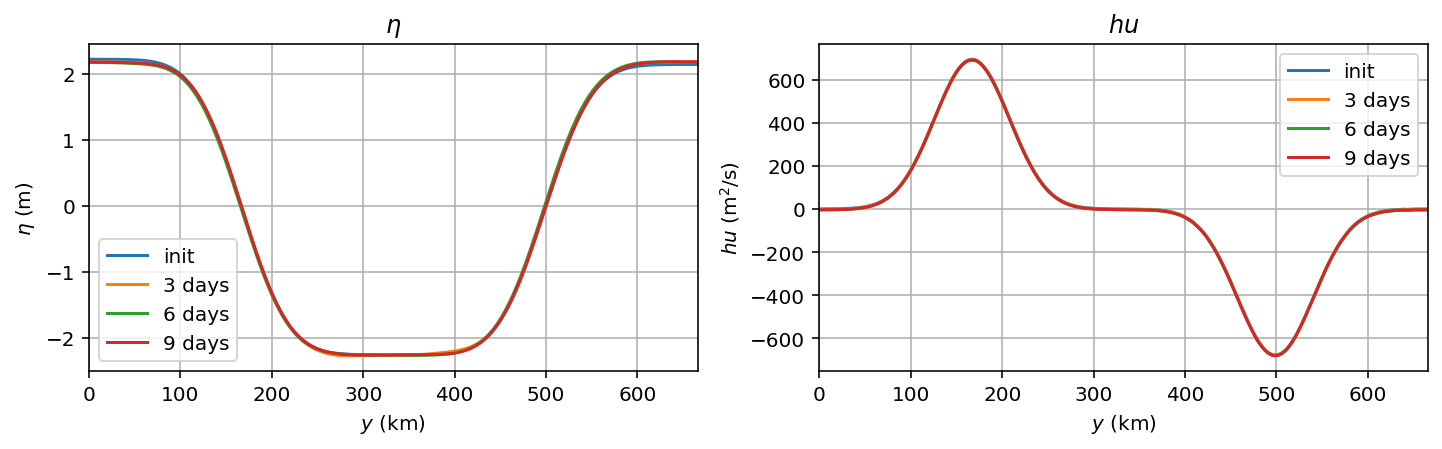

In [15]:
from gpuocean.SWEsimulators import KP07

import copy
sim_args = copy.copy(steadyStateCase_args)
sim_args.pop("dt", None)
sim_args.pop("rk_order", None)
for key in steadyStateCase_args.keys():
    if key.startswith("small"):
        sim_args.pop(key, None)

su_kp_sim = KP07.KP07(**sim_args, dt=1.0, **steadyStateCase_init, use_rk2=True, flux_balancer=1.0, theta=1.3)
run_doublejet(su_kp_sim)

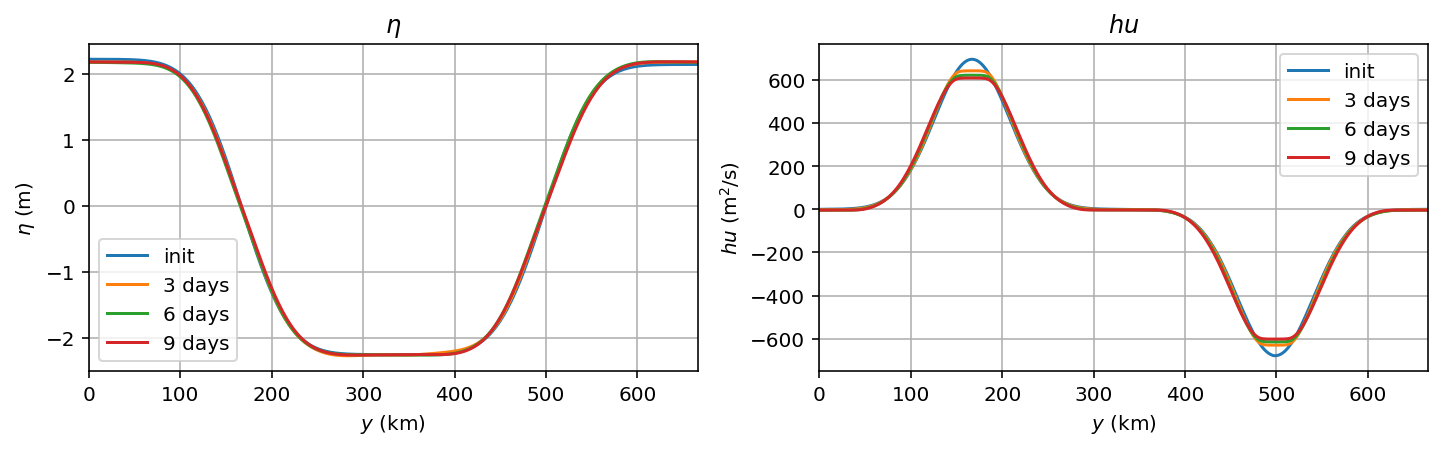

In [16]:
cu_kp_sim = KP07.KP07(**sim_args, dt=1.0, **steadyStateCase_init, use_rk2=True, flux_balancer=0.0, theta=1.3)
run_doublejet(cu_kp_sim)

### CDKLM with SU with $\theta= 1$ and $\theta = 2$

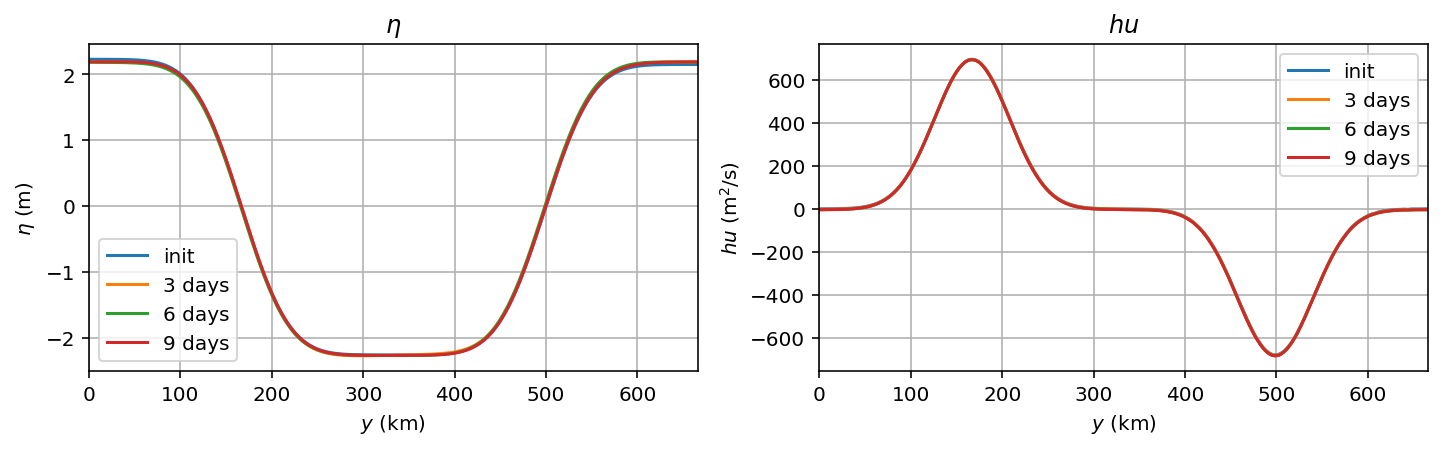

In [17]:
su_sim1 = CDKLM16.CDKLM16(**steadyStateCase_args, **steadyStateCase_init, flux_balancer=1.0, theta=1.0)
run_doublejet(su_sim1)

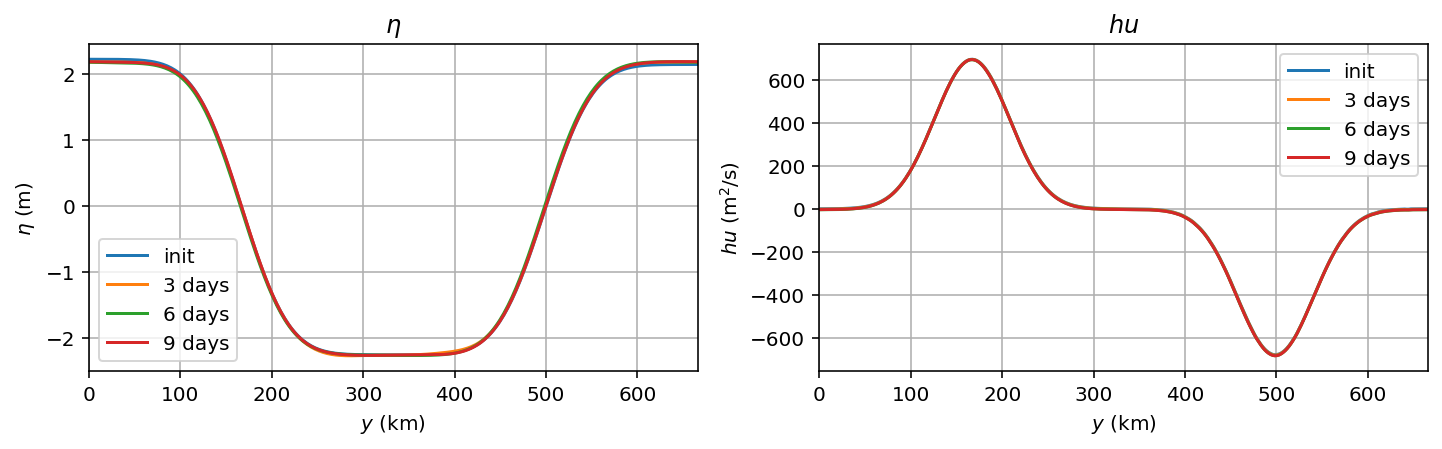

In [18]:
su_sim2 = CDKLM16.CDKLM16(**steadyStateCase_args, **steadyStateCase_init, flux_balancer=1.0, theta=2.0)
run_doublejet(su_sim2)

### Analysis of the momentum loss

In [19]:
print(steadyStateCase_init["hu0"][2:-2,2:-2][75][0], np.max(cu_sim1.download()[1][2:-2,2:-2]), np.max(cu_sim2.download()[1][2:-2,2:-2]), np.max(cu_sim3.download()[1][2:-2,2:-2]))

print(steadyStateCase_init["hu0"][2:-2,2:-2][75][0]/steadyStateCase_init["hu0"][2:-2,2:-2][75][0], np.max(cu_sim1.download()[1][2:-2,2:-2])/steadyStateCase_init["hu0"][2:-2,2:-2][75][0], np.max(cu_sim2.download()[1][2:-2,2:-2])/steadyStateCase_init["hu0"][2:-2,2:-2][75][0], np.max(cu_sim3.download()[1][2:-2,2:-2])/steadyStateCase_init["hu0"][2:-2,2:-2][75][0])

694.9981 397.85785 610.22363 663.7047
1.0 0.5724589 0.878022 0.9549734


In [20]:
for phi in np.arange(0.6, 0.7, -0.05):
    phi_sim = CDKLM16.CDKLM16(**steadyStateCase_args, **steadyStateCase_init, flux_balancer=phi, theta=1.8)
    phi_sim.step(9*24*60*60)
    print("phi = ", phi,". Loss = ", 1-np.max(phi_sim.download()[1][2:-2,2:-2])/steadyStateCase_init["hu0"][2:-2,2:-2][75][0])

In [21]:
for phi in np.arange(0.55, 0.5, -0.01):
    phi_sim = CDKLM16.CDKLM16(**steadyStateCase_args, **steadyStateCase_init, flux_balancer=phi, theta=1.8)
    phi_sim.step(9*24*60*60)
    print("phi = ", phi,". Loss = ", 1-np.max(phi_sim.download()[1][2:-2,2:-2])/steadyStateCase_init["hu0"][2:-2,2:-2][75][0])

phi =  0.55 . Loss =  0.04337960481643677
phi =  0.54 . Loss =  0.04389983415603638
phi =  0.53 . Loss =  0.044402897357940674
phi =  0.52 . Loss =  0.0449184775352478
phi =  0.51 . Loss =  0.04541689157485962
phi =  0.5 . Loss =  0.04591637849807739
